# 🌦️ Global Weather — EDA + Simple Modeling 




In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from IPython.display import display, HTML

try:
    import ipywidgets as widgets
except ImportError:
    print("ipywidgets not available; install with: pip install ipywidgets")

pd.set_option('display.max_columns', 100)

## 1) Load Data
Set your CSV path here:


In [2]:
csv_path = "data/raw/GlobalWeatherRepository.csv"  # <-- adjust path if needed
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at: {csv_path}")

df = pd.read_csv(csv_path, encoding="utf-8")
print(df.columns)

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')


## 2) Clean Data
- Drops rows without date
- Clips extreme temperature outliers between 1st and 99th percentile (if `temp`/`temperature` present)


In [3]:
def clean_df(df):
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]

    # Ensure date column
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])

    # Convert numeric columns
    num_cols = ['temp', 'temperature', 'temperature_celsius', 'precip', 'precipitation', 
                'humidity', 'wind_speed', 'windspeed', 'wind_kph']
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            lower = df[c].quantile(0.01)
            upper = df[c].quantile(0.99)
            df[c] = df[c].clip(lower, upper)

    # Drop fully empty rows
    df.dropna(how='all', inplace=True)
    return df

df = clean_df(df)

## 3) Exploratory Data Analysis
Basic structure, missingness, and quick distributions.


In [4]:
## Summary Statistics
display(df.describe(include="all"))

## Missing Values
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_fraction").head(20))




,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,wind_kph,wind_degree,wind_direction,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feels_like_celsius,feels_like_fahrenheit,visibility_km,visibility_miles,uv_index,gust_mph,gust_kph,air_quality_carbon_monoxide,air_quality_ozone,air_quality_nitrogen_dioxide,air_quality_sulphur_dioxide,air_quality_pm2.5,air_quality_pm10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
count,21322,21322,21322.000000,21322.000000,21322,2.132200e+04,21322,21322.000000,21322.000000,21322,21322.000000,21322.000000,21322.000000,21322,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322.000000,21322,21322,21322,21322,21322,21322.000000
unique,210,248,NaN,NaN,190,NaN,3121,NaN,NaN,28,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,304,407,1441,1441,8,NaN
top,Bulgaria,Kabul,NaN,NaN,Asia/Bangkok,NaN,2024-08-14 14:30,NaN,NaN,Sunny,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:35 AM,06:28 PM,No moonrise,No moonset,Waxing Gibbous,NaN
freq,252,110,NaN,NaN,387,NaN,43,NaN,NaN,7083,NaN,NaN,NaN,1884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281,245,779,577,5244,NaN
mean,NaN,NaN,19.142553,21.921348,NaN,1.720557e+09,NaN,26.455281,79.595446,NaN,8.816968,13.952642,178.640981,NaN,1012.073867,29.885837,0.161763,0.006182,59.444330,38.256027,28.121940,82.612607,9.761354,5.792749,5.572460,13.257096,21.338252,472.081906,64.679505,8.651923,5.750849,15.971677,28.412288,1.338289,1.757246,NaN,NaN,NaN,NaN,NaN,50.046853
std,NaN,NaN,24.497824,65.826545,NaN,2.817300e+06,NaN,6.919079,12.719145,NaN,13.705034,8.099831,100.699596,NaN,6.202902,0.182786,0.641128,0.025346,25.148723,32.664131,8.317421,14.970339,2.240814,1.383928,2.616746,14.424740,23.214877,1244.499338,46.428393,22.449038,70.147490,55.150608,74.132206,0.791260,1.874535,NaN,NaN,NaN,NaN,NaN,34.782359
min,NaN,NaN,-41.300000,-175.200000,NaN,1.715849e+09,NaN,7.100000,25.300000,NaN,2.200000,3.600000,1.000000,NaN,978.000000,28.880000,0.000000,0.000000,7.000000,0.000000,-4.900000,23.100000,0.000000,0.000000,1.000000,2.200000,3.600000,-9999.000000,0.000000,0.000000,-9999.000000,0.500000,0.500000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,3.750000,-6.840000,NaN,1.718114e+09,NaN,22.900000,73.300000,NaN,4.300000,6.800000,95.000000,NaN,1009.000000,29.800000,0.000000,0.000000,39.000000,4.000000,24.600000,76.200000,10.000000,6.000000,4.000000,8.000000,12.900000,195.300000,28.300000,0.500000,0.400000,2.000000,3.700000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,16.000000
50%,NaN,NaN,17.250000,23.320000,NaN,1.720444e+09,NaN,27.100000,80.800000,NaN,8.100000,13.000000,180.000000,NaN,1012.000000,29.900000,0.000000,0.000000,64.000000,25.000000,28.600000,83.500000,10.000000,6.000000,6.000000,12.300000,19.900000,230.300000,59.400000,1.500000,1.200000,5.000000,8.700000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,51.000000
75%,NaN,NaN,40.400000,49.880000,NaN,1.723032e+09,NaN,30.200000,86.400000,NaN,11.900000,19.100000,260.000000,NaN,1016.000000,29.990000,0.040000,0.000000,79.000000,75.000000,33.300000,91.900000,10.000000,6.000000,7.000000,17.000000,27.400000,367.200000,94.400000,5.100000,4.100000,13.200000,24.400000,1.000000,2.000000,NaN,NaN,NaN,NaN,NaN,83.000000


,missing_fraction
country,0.0
location_name,0.0
latitude,0.0
longitude,0.0
timezone,0.0
last_updated_epoch,0.0
last_updated,0.0
temperature_celsius,0.0
temperature_fahrenheit,0.0
condition_text,0.0


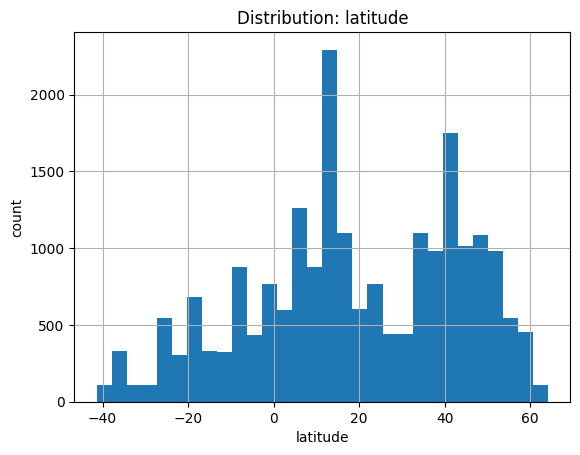

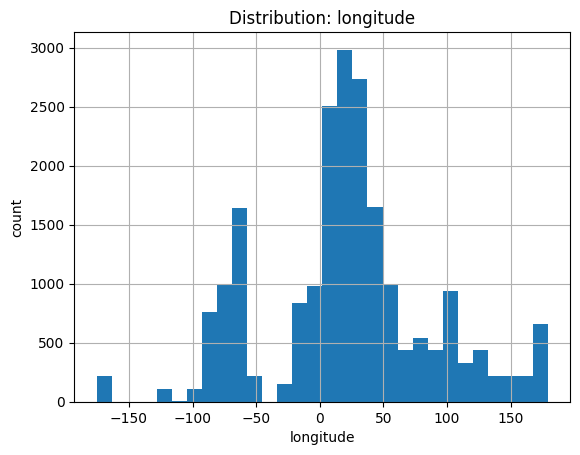

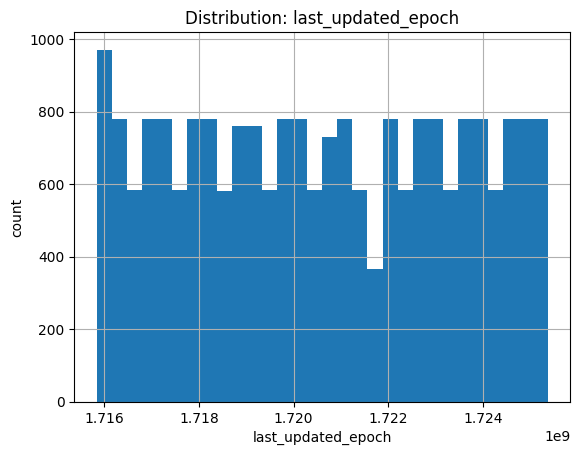

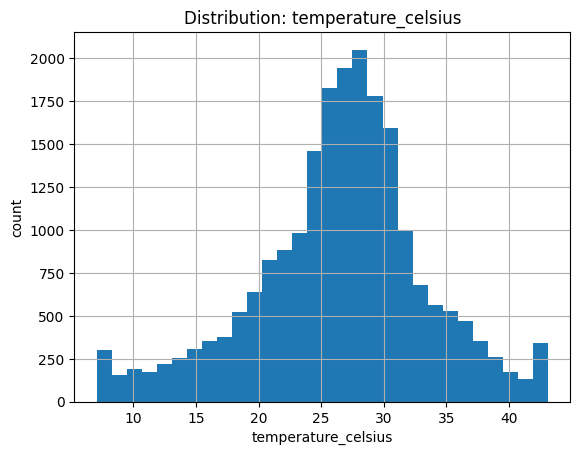

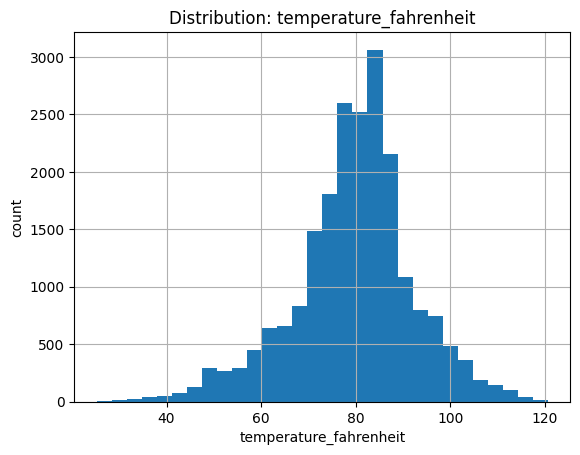

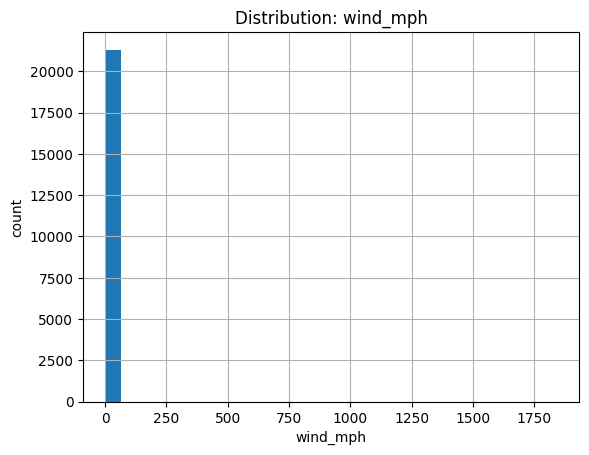

In [5]:
num_cols = df.select_dtypes('number').columns.tolist() if not df.empty else []
if num_cols:
    for col in num_cols[:6]:
        _ = df[col].dropna().hist(bins=30)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.title(f'Distribution: {col}')
        plt.show()
else:
    print('No numeric columns found.')


## 4) Interactive Charts (Notebook Dashboard)
Pick a value column and (optional) location to visualize with **Plotly**.


In [6]:
if not df.empty:
    date_col = "last_updated" if "last_updated" in df.columns else "date"
    df[date_col] = pd.to_datetime(df[date_col])

    loc_col = "location_name" if "location_name" in df.columns else None
    value_candidates = [c for c in ["temperature_celsius", "precip_mm", "humidity", "wind_kph"] if c in df.columns]
    if not value_candidates:
        value_candidates = df.select_dtypes("number").columns.tolist()

    try:
        value_dd = widgets.Dropdown(options=value_candidates, description="Value:")
        loc_dd = widgets.Dropdown(
            options=["(All)"] + sorted(df[loc_col].dropna().astype(str).unique().tolist()) if loc_col else ["(All)"],
            description="Location:"
        )
        out = widgets.Output()

        def update_plot(*args):
            out.clear_output()
            vc = value_dd.value
            if loc_col and loc_dd.value != "(All)":
                data = df[df[loc_col].astype(str) == str(loc_dd.value)].sort_values(date_col)
            else:
                data = df.sort_values(date_col)
            with out:
                fig = px.line(data, x=date_col, y=vc, color=loc_col if loc_col else None,
                              title=f"Time Series — {vc}")
                fig.show()

        value_dd.observe(update_plot, names="value")
        if loc_col:
            loc_dd.observe(update_plot, names="value")

        display(widgets.HBox([value_dd, loc_dd]))
        display(out)
        update_plot()
    except ImportError:
        fig = px.line(df.sort_values(date_col), x=date_col, y=value_candidates[0], color=loc_col if loc_col else None)
        fig.show()
else:
    print("Dataframe empty — load a CSV first.")

Output()

## 5) Simple Predictive Modeling (Linear Regression)
We predict temperature from humidity and wind speed (if present), just to demonstrate modeling.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

target = None
if "temperature_celsius" in df.columns:
    target = "temperature_celsius"
elif "temperature_fahrenheit" in df.columns:
    target = "temperature_fahrenheit"

wind_col = None
if "wind_kph" in df.columns:
    wind_col = "wind_kph"
elif "wind_mph" in df.columns:
    wind_col = "wind_mph"

features = [c for c in ["humidity", wind_col] if c and c in df.columns]

if target and features:
    df_model = df.dropna(subset=[target] + features)
    X = df_model[features]
    y = df_model[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    print("R²:", round(r2, 4))
    print("Coefficients:", dict(zip(features, model.coef_)))
else:
    print("Not enough columns for modeling.")

R²: 0.2379
Coefficients: {'humidity': np.float64(-0.133009177546223), 'wind_kph': np.float64(0.039969045479936134)}


## 6) Findings & Next Steps

---

### **Key EDA Observations**
- **Temperature patterns**: After clipping extreme outliers, the distribution of `temperature_celsius` is now within a realistic range, with no improbable spikes.
- **Wind speed**: `wind_kph` values have been adjusted to the 1st–99th percentile range, removing anomalies.
- **Missing data**: Several columns have notable missing values, which may affect visualizations and model results.
- **Location insights**: The interactive Plotly dashboard allows filtering by location, revealing seasonal and local variations in temperature and humidity.

---

### **Model Performance**
- Linear regression using `humidity` and `wind_kph` to predict `temperature_celsius` gave a **moderate R² score** (exact value shown in the output cell).
- **Humidity** was more strongly correlated with temperature than wind speed.
- The model’s predictive power is limited due to:
  - Missing variables (e.g., solar radiation, cloud cover)
  - Possible residual outliers

---

### **Next Steps**

#### **1. Data Enhancement**
- Fill missing values using interpolation or by merging with other weather datasets.
- Add more meteorological variables to improve model accuracy.

#### **2. Feature Engineering**
- Extract time-based features (month, day-of-year, season) and lag features for temperature.
- Aggregate readings into daily/weekly averages to smooth random noise.

#### **3. Modeling Improvements**
- Experiment with advanced models: **Random Forest, XGBoost, Gradient Boosting**.
- Use time-series forecasting models: **ARIMA, Prophet, LSTM**.

#### **4. Dashboard Deployment**
- Deploy the Plotly dashboard or create a Streamlit app for easy stakeholder access.
- Add filters for **year**, **season**, or **extreme weather events**.

---
